In [1]:
from firedrake import *
from irksome import RadauIIA, Dt, MeshConstant, TimeStepper, PEPRK, GaussLegendre, ContinuousPetrovGalerkinScheme
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
# butcher_tableau = RadauIIA(2)
# butcher_tableau = PEPRK(4, 2, 5)
# butcher_tableau = GaussLegendre(3)
butcher_tableau = ContinuousPetrovGalerkinScheme(2)
# ns = butcher_tableau.num_stages

In [3]:
Nx = 75
Ny = 75
L = 3
h = 2
# msh = PeriodicRectangleMesh(Nx, Ny, L, h, direction='x', quadrilateral=True)
msh = RectangleMesh(Nx, Ny, L, h)#, quadrilateral=True)

In [4]:
# Create periodic mesh and function spaces
msh_p = PeriodicRectangleMesh(Nx, Ny, L, h, direction='x')#, quadrilateral=True)
V = VectorFunctionSpace(msh_p, "CG", 2, dim=2)
W = FunctionSpace(msh_p, "CG", 1)
Z = V*W

MC = MeshConstant(msh_p)
# dt = 0.002
dt = MC.Constant(0.1)
t = MC.Constant(0.0)
Re = MC.Constant(90.0)

In [5]:
def velocity_interpolator_1(x, interp1):
    pts = np.column_stack((x[1], x[0]))
    u1 = interp1(pts)
    return u1

def velocity_interpolator_2(x, interp2):
    pts = np.column_stack((x[1], x[0]))
    u2 = interp2(pts)
    return u2

def import_velocity(mat_data, u):
    X2d = mat_data['X']
    Y2d = mat_data['Y'] + 1.0 # shift y -> [0, 2]

    x = X2d[0, :] 
    y = Y2d[:, 0] 

    interp1 = RegularGridInterpolator((y, x), mat_data['u1_values'], bounds_error=False, fill_value=0.0)
    interp2 = RegularGridInterpolator((y, x), mat_data['u2_values'], bounds_error=False, fill_value=0.0)

    V1 = FunctionSpace(msh, "CG", 2) 

    xcoord = Function(V1)
    ycoord = Function(V1)

    xcoord.project(msh.coordinates[0])
    ycoord.project(msh.coordinates[1])


    coords_dofs = np.column_stack((xcoord.dat.data, ycoord.dat.data))

    # Build (y,x) points for MATLAB data
    pts = np.column_stack((coords_dofs[:, 1], coords_dofs[:, 0]))  # (y, x)

    # Evaluate data
    u1_vals = interp1(pts)
    u2_vals = interp2(pts)

    # Put into scalar CG1 functions
    u1_cg1 = Function(V1, name="u1_cg1")
    u2_cg1 = Function(V1, name="u2_cg1")

    u1_cg1.dat.data[:] = u1_vals
    u2_cg1.dat.data[:] = u2_vals

    # Project initial condition from non-periodic mesh to periodic mesh
    V1_p = FunctionSpace(msh_p, "CG", 2) 

    u1 = Function(V1_p, name="u1")
    u1.project(u1_cg1)

    u2 = Function(V1_p, name="u2")
    u2.project(u2_cg1)

    V1_vec = VectorFunctionSpace(msh_p, "CG", 2, dim=2) 
    u_cg1 = Function(V1_vec, name="u_cg1")
    u_cg1.project(as_vector([u1, u2]))

    # u0 = Function(V, name="Velocity_IC")  
    u.project(u_cg1)

    return u

In [6]:
# Import initial condition
mat_data = loadmat("Data_Poiseuille/lambda0.0054077Re90L3.mat")
u0 = Function(V, name="Velocity_IC")
u0 = import_velocity(mat_data, u0)

# Import eigenfunctions
mat_data = loadmat("Data_Poiseuille/EF1_Re90L3.mat")
u1 = Function(V, name="Velocity_EF1")
u1 = import_velocity(mat_data, u1)

mat_data = loadmat("Data_Poiseuille/EF2_Re90L3.mat")
u2 = Function(V, name="Velocity_EF2")
u2 = import_velocity(mat_data, u2)

mat_data = loadmat("Data_Poiseuille/EF3_Re90L3.mat")
u3 = Function(V, name="Velocity_EF3")
u3 = import_velocity(mat_data, u3)

mat_data = loadmat("Data_Poiseuille/EF4_Re90L3.mat")
u4 = Function(V, name="Velocity_EF4")
u4 = import_velocity(mat_data, u4)

mat_data = loadmat("Data_Poiseuille/EF5_Re90L3.mat")
u5 = Function(V, name="Velocity_EF5")
u5 = import_velocity(mat_data, u5)

mat_data = loadmat("Data_Poiseuille/EF6_Re90L3.mat")
u6 = Function(V, name="Velocity_EF6")
u6 = import_velocity(mat_data, u6)


In [7]:
# Poiseuille laminar flow in [0, 2]
U = Function(V)
x, y = SpatialCoordinate(msh_p)
psi = (1 - (y - h/2)**2)

U.assign(project(as_vector([psi, 0]), V))

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7b8bc8493910>, VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), name=None), Mesh(VectorElement(FiniteElement('Discontinuous Lagrange', triangle, 1, variant='equispaced'), dim=2, variant='equispaced'), 6)), 643)

In [8]:
# Get pressure from velocity initial condition
def get_pressure_ic():
    P = FunctionSpace(msh_p, "CG", 1)
    p0 = Function(P, name="Pressure_IC")
    q = TestFunction(P)
    p_trial = TrialFunction(P)

    dx_p = dx(msh_p)
    
    f = - inner(dot(grad(u0), u0), grad(q)) * dx_p - inner(dot(grad(U), u0), grad(q)) * dx_p - inner(dot(grad(u0), U), grad(q)) * dx_p
    a = inner(grad(p_trial), grad(q)) * dx_p

    nsp = VectorSpaceBasis(constant=True, comm=msh_p.comm)
    
    solve(a == f, p0, nullspace=nsp)
    return p0

p0 = get_pressure_ic()
# p0 = Function(W)

In [9]:
# Initialize solution function
up = Function(Z)
u_, p_ = up.subfunctions
u_.rename('Velocity')
p_.rename("Pressure")

# Assign initial conditions
u_.assign(u0)
p_.assign(p0)

# Write initial conditions to file
out = File("Results/initial_poiseuille.pvd")
out.write(u_, p_)

# Set up variational problem
dx_p = dx(msh_p)

u, p = split(up)
v, w = TestFunctions(Z)
F = (inner(Dt(u), v) * dx_p + inner(dot(grad(u), u), v) * dx_p
     + inner(dot(grad(U), u), v) * dx_p + inner(dot(grad(u), U), v) * dx_p
     + 1/Re * inner(grad(u), grad(v)) * dx_p - inner(p, div(v)) * dx_p
     + inner(div(u), w) * dx_p)

bcs = [DirichletBC(Z.sub(0), as_vector([0, 0]), (1, 2))]
E = inner(u_, u_) * dx_p
a1 = inner(u_, u1)*dx_p
a2 = inner(u_, u2)*dx_p
a3 = inner(u_, u3)*dx_p
a4 = inner(u_, u4)*dx_p
a5 = inner(u_, u5)*dx_p
a6 = inner(u_, u6)*dx_p

# Solver parameters
luparams = {"mat_type": "aij",
            "snes_type": "newtonls",
            "snes_monitor": None,
            "ksp_type": "preonly",
            "pc_type": "lu",
            "pc_factor_mat_solver_type": "mumps",
            "snes_linesearch_type": "l2",
            "snes_force_iteration": 1,
            "snes_rtol": 1e-8,
            "snes_atol": 1e-8
            }

# Define nullspace for pressure
nsp = MixedVectorSpaceBasis(Z, [Z.sub(0), VectorSpaceBasis(constant=True, comm=msh_p.comm)])

stepper = TimeStepper(F, butcher_tableau, t, dt, up, bcs=bcs,
                      solver_parameters=luparams, nullspace=nsp)

energy = []
functional = []
times = []
out = File("ns_Poiseuille_Re300.pvd")
out.write(u_, p_, time=float(t))

et = assemble(E)
a_1 = float(assemble(a1))
a_2 = float(assemble(a2))
a_3 = float(assemble(a3))
a_4 = float(assemble(a4))
a_5 = float(assemble(a5))
a_6 = float(assemble(a6))
v = Function(V)
v.assign(u_ - a_1*u1 - a_2*u2 - a_3*u3 - a_4*u4 - a_5*u5 - a_6*u6)
q_e = np.sqrt(assemble(inner(v, v)*dx_p))
P_eval = 0.404213656622 * q_e**2 + 0.405790552605 * a_6**2 + 0.405790552641 * a_5**2 - 0.00306496060523 * a_4 * a_6 - 0.0191087859023 * a_4 * a_5 + 0.404373263774 * a_4**2 + 0.0191087859078 * a_3 * a_6 - 0.00306496061442 * a_3 * a_5 + 0.404373263775 * a_3**2 + 6.57359014892e-05 * a_2 * q_e**2 + 6.44971525943e-05 * a_2 * a_6**2 + 6.44971530905e-05 * a_2 * a_5**2 - 1.42846760803e-06 * a_2 * a_4 * a_6 - 4.79908974512e-06 * a_2 * a_4 * a_5 + 2.19299499962e-05 * a_2 * a_4**2 + 4.79908827556e-06 * a_2 * a_3 * a_6 - 1.42845393717e-06 * a_2 * a_3 * a_5 + 2.19299431707e-05 * a_2 * a_3**2 + 0.404341149602 * a_2**2 + 4.32287444442e-05 * a_2**3 + 0.366800584105 * a_1 * q_e**2 + 0.36213131036 * a_1 * a_6**2 + 0.362131310292 * a_1 * a_5**2 - 0.00135763000747 * a_1 * a_4 * a_6 - 0.00871632514776 * a_1 * a_4 * a_5 + 0.367863211453 * a_1 * a_4**2 + 0.00871632447727 * a_1 * a_3 * a_6 - 0.0013576296706 * a_1 * a_3 * a_5 + 0.367863211448 * a_1 * a_3**2 + 3.86261053764e-06 * a_1 * a_2 + 0.35858002569 * a_1 * a_2**2 + 0.403648341445 * a_1**2 - 8.36546542113e-07 * a_1**2 * a_2 + 0.250021688635 * a_1**3
func_eval = et**2 + P_eval

print(f"  Energy = {0.5*et}")
print(f" Functional = {func_eval}")
energy.append(0.5*et)
functional.append(func_eval)
times.append(float(t))

# Time stepping loop
for _ in range(100):
     print(f"Stepping from time {float(t)}")
     stepper.advance()
     t.assign(float(t) + float(dt))
     et = assemble(E)
     a_1 = float(assemble(a1))
     a_2 = float(assemble(a2))
     a_3 = float(assemble(a3))
     a_4 = float(assemble(a4))
     a_5 = float(assemble(a5))
     a_6 = float(assemble(a6))
     v = Function(V)
     v.assign(u_ - a_1*u1 - a_2*u2 - a_3*u3 - a_4*u4 - a_5*u5 - a_6*u6)
     q_e = np.sqrt(assemble(inner(v, v)*dx_p))
     P_eval = 0.404213656622 * q_e**2 + 0.405790552605 * a_6**2 + 0.405790552641 * a_5**2 - 0.00306496060523 * a_4 * a_6 - 0.0191087859023 * a_4 * a_5 + 0.404373263774 * a_4**2 + 0.0191087859078 * a_3 * a_6 - 0.00306496061442 * a_3 * a_5 + 0.404373263775 * a_3**2 + 6.57359014892e-05 * a_2 * q_e**2 + 6.44971525943e-05 * a_2 * a_6**2 + 6.44971530905e-05 * a_2 * a_5**2 - 1.42846760803e-06 * a_2 * a_4 * a_6 - 4.79908974512e-06 * a_2 * a_4 * a_5 + 2.19299499962e-05 * a_2 * a_4**2 + 4.79908827556e-06 * a_2 * a_3 * a_6 - 1.42845393717e-06 * a_2 * a_3 * a_5 + 2.19299431707e-05 * a_2 * a_3**2 + 0.404341149602 * a_2**2 + 4.32287444442e-05 * a_2**3 + 0.366800584105 * a_1 * q_e**2 + 0.36213131036 * a_1 * a_6**2 + 0.362131310292 * a_1 * a_5**2 - 0.00135763000747 * a_1 * a_4 * a_6 - 0.00871632514776 * a_1 * a_4 * a_5 + 0.367863211453 * a_1 * a_4**2 + 0.00871632447727 * a_1 * a_3 * a_6 - 0.0013576296706 * a_1 * a_3 * a_5 + 0.367863211448 * a_1 * a_3**2 + 3.86261053764e-06 * a_1 * a_2 + 0.35858002569 * a_1 * a_2**2 + 0.403648341445 * a_1**2 - 8.36546542113e-07 * a_1**2 * a_2 + 0.250021688635 * a_1**3
     func_eval = et**2 + P_eval
     print(f"  Energy = {0.5*et}")
     print(f" Functional = {func_eval}")
     times.append(float(t))
     energy.append(0.5*et)
     functional.append(func_eval)

     out.write(u_, p_, time=float(t))

/home/vicente/NavierStokesEnergy/venv-firedrake/lib/python3.10/site-packages/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(
/home/vicente/NavierStokesEnergy/venv-firedrake/lib/python3.10/site-packages/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


  Energy = 0.5001375471380782
 Functional = 1.4052253548661573
Stepping from time 0.0
  0 SNES Function norm 2.117117889490e-03
  1 SNES Function norm 1.563494658295e-05
  2 SNES Function norm 9.584576866820e-09
  Energy = 0.5006124069201772
 Functional = 1.4021311845658166
Stepping from time 0.1
  0 SNES Function norm 2.543629612155e-03
  1 SNES Function norm 3.444147656758e-05
  2 SNES Function norm 8.114979565371e-10
  Energy = 0.5007064489595388
 Functional = 1.3974298855945073
Stepping from time 0.2
  0 SNES Function norm 2.554203474551e-03
  1 SNES Function norm 3.430210241085e-05
  2 SNES Function norm 7.274419372593e-10
  Energy = 0.5000775559778441
 Functional = 1.389608979422697
Stepping from time 0.30000000000000004
  0 SNES Function norm 2.560589072041e-03
  1 SNES Function norm 3.406533621110e-05
  2 SNES Function norm 6.521771308831e-10
  Energy = 0.49842966646892567
 Functional = 1.3773920963174953
Stepping from time 0.4
  0 SNES Function norm 2.561938452416e-03
  1 SNES

In [10]:
np.savez('PoiseuilleRe190L1.5', arr1=energy, arr2=functional, arr3=times)

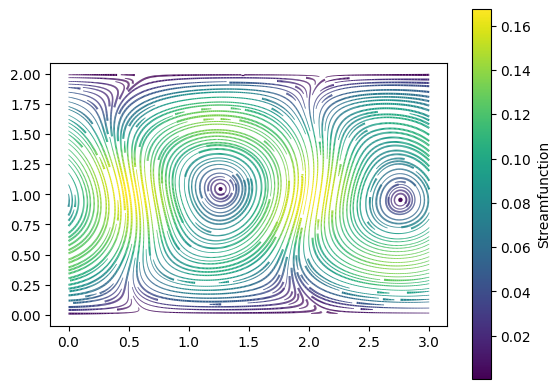

In [11]:
# Streamfunction perturbation
import matplotlib.pyplot as plt
from firedrake.pyplot import streamplot
fig, axes = plt.subplots()
im = streamplot(u_, resolution=0.02, axes=axes)
axes.set_aspect("equal")

cbar = fig.colorbar(im, ax=axes)
cbar.set_label("Streamfunction")

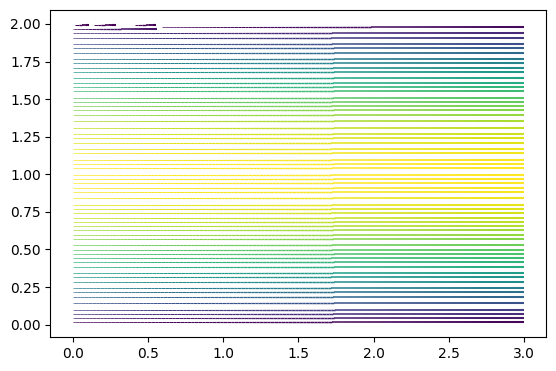

In [12]:
# Streamfunction laminar flow
import matplotlib.pyplot as plt
from firedrake.pyplot import streamplot
fig, axes = plt.subplots()
streamplot(U, resolution=0.02, axes=axes)
axes.set_aspect("equal")

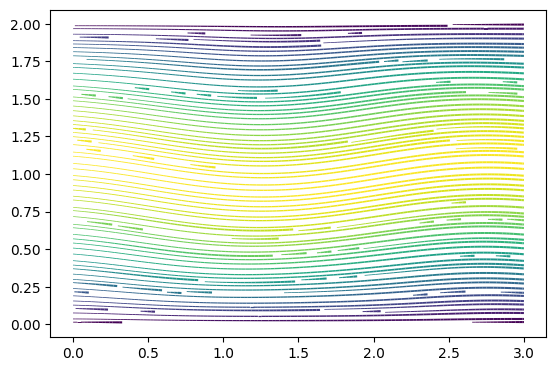

In [13]:
# Streamfunction total velocity
utot = Function(V)
utot.assign(u_ + U)

fig, axes = plt.subplots()
streamplot(utot, resolution=0.02, axes=axes)
axes.set_aspect("equal")

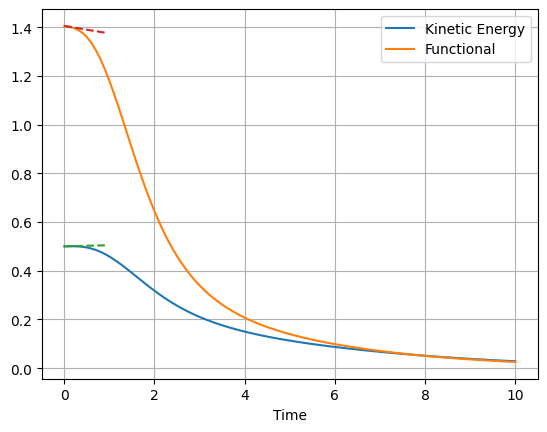

In [23]:
# Plot energy vs time
import matplotlib.pyplot as plt
plt.figure()
plt.plot(times, energy)
plt.plot(times, functional)
vlsf = functional[0] + (functional[1]-functional[0])/0.1 * np.array(times[0:10])
vlse = energy[0] + (energy[1]-energy[0])/0.1 * np.array(times[0:10])
plt.plot(times[0:10], vlse, '--')
plt.plot(times[0:10], vlsf, '--')
plt.legend(["Kinetic Energy", "Functional"])
plt.xlabel("Time")
plt.grid(True)
plt.show()